In [1]:
library(tidyverse)
library(modelr)
library(broom)
library(rsample)
library(rcfss)
library(magrittr)
library(titanic)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘broom’

The following object is masked from ‘package:modelr’:

    bootstrap


Attaching package: ‘rsample’

The following object is masked from ‘package:tidyr’:

    fill


Attaching package: ‘rcfss’

The following object is masked from ‘package:modelr’:

    mse


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



# Why do we need resampling method?
The question is actually related to the difference between training and testing. Training error cannot reflect how well a trained model can be generalised to unseen data. What we want is to predict or explain new observations that occur in the future. However, the real world scenarios are that we only have the historical data while training a model. How do we know the performance of a model trained on the historical data on the unseen data? 

One choice for us is to mimics the prediction by spliting the historical data into training and testing sets with sampling methods.

Let's start with some simulation.

In [2]:
set.seed(1234)

Generate 50 random samples for 

$
Y = 3 + 0.05 * \mathbf{X} + 0.05 * \mathbf{X}^2 + 0.05 * \mathbf{X}^3 + \mbox{N}(\mu, \sigma^2)
$

In [3]:
sim_mse <- data_frame(X = runif(50, 0, 10), Y = 3 + .05 * X + .05 * X^2 + .05 * X^3 + rnorm(50, 0, 4))

Building 3 linear models using different poly degrees of X 

In [4]:
# linear model
sim_mse_1 <- lm(Y ~ poly(X, 1), data = sim_mse)

In [5]:
# third-order poly
sim_mse_3 <- lm(Y ~ poly(X, 3), data = sim_mse)

In [6]:
# tenth-order poly
sim_mse_10 <- lm(Y ~ poly(X, 10), data = sim_mse)

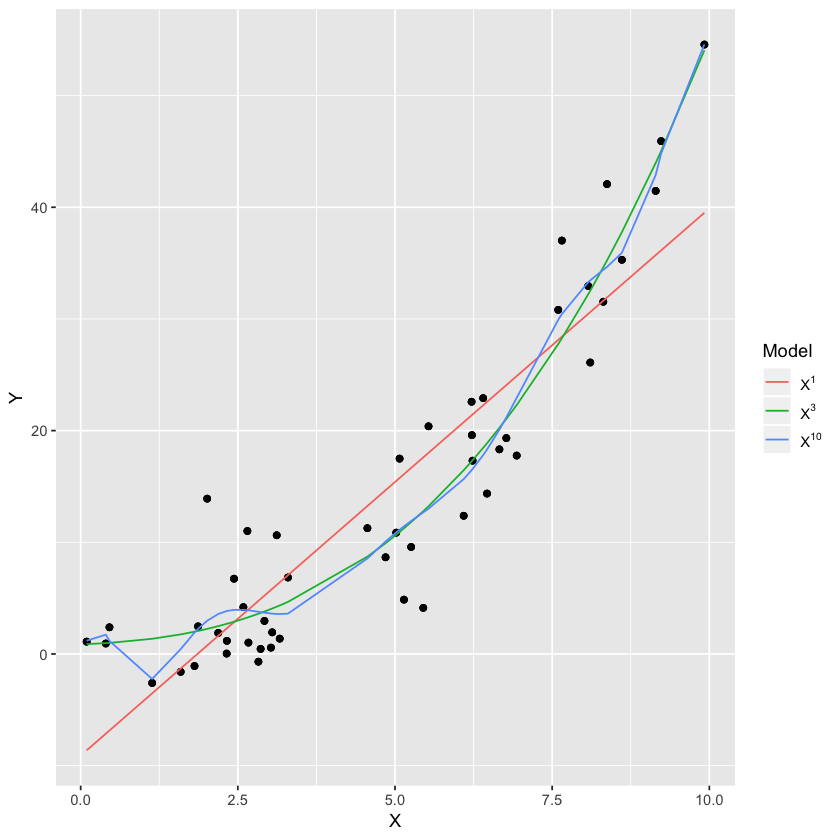

In [7]:
# add predictions and plot
sim_mse %>%
  gather_predictions(sim_mse_1, sim_mse_3, sim_mse_10) %>%
  mutate(model = factor(model, levels = c("sim_mse_1", "sim_mse_3", "sim_mse_10"), labels = c("X^1", "X^3", "X^10"))) %>%
  ggplot(aes(X)) +
  geom_point(aes(y = Y)) +
  geom_line(aes(y = pred, color = model)) +
  scale_color_discrete(labels = c(expression(X^1), expression(X^3), expression(X^10))) +
  labs(color = "Model") +
  theme(legend.text.align = 0)

How does "gather_predictions()" work? You can run the following code to see how the function works.

```
df <- tibble::data_frame(
  x = sort(runif(100)),
  y = 5 * x + 0.5 * x ^ 2 + 3 + rnorm(length(x))
)
plot(df)

m1 <- lm(y ~ x, data = df)
grid <- data.frame(x = seq(0, 1, length = 10))
grid %>% add_predictions(m1)

m2 <- lm(y ~ poly(x, 2), data = df)
grid %>% spread_predictions(m1, m2)
grid %>% gather_predictions(m1, m2)
```

The above plot shows that 
* The relationship between X and Y is not linear.
* The polynomial fits are better than the linear fit.
* The higher the order of a polynomial function, the more likely the overfit will happen.

Now, the question is 
* what is the best degree of polynomial should be used in the fitting?

### What is the training MSE

In [8]:
data_frame(terms = c(1, 3, 10), model = list(sim_mse_1, sim_mse_3, sim_mse_10)) %>%
  mutate(mse = map_dbl(model, mse, data = sim_mse)) %>%
  select(-model) %>%
  knitr::kable(caption = "Training MSEs", col.names = c("Highest-order term", "MSE"))



| Highest-order term|      MSE|
|------------------:|--------:|
|                  1| 38.16658|
|                  3| 18.08841|
|                 10| 17.17621|

Given the training MSE, it seems that we can use the 10th-order polynomial, as it provides the lowest MSE.

### What is the testing MSE?



In [9]:
# simulate test data
sim_mse_test <- data_frame(X = runif(50, 0, 10), Y = 3 + .05 * X + .05 * X^2 + .05 * X^3 + rnorm(50, 0, 4))

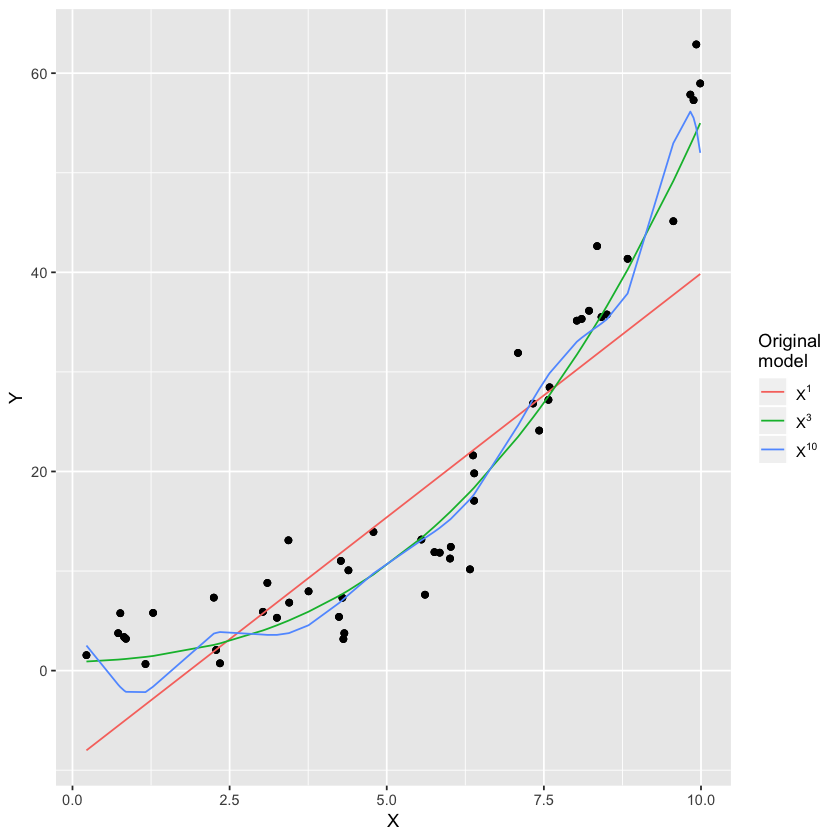

In [10]:
# draw graph with new points and original models
sim_mse_test %>%
  gather_predictions(sim_mse_1, sim_mse_3, sim_mse_10) %>%
  mutate(model = factor(model, levels = c("sim_mse_1", "sim_mse_3", "sim_mse_10"), labels = c("X^1", "X^3", "X^10"))) %>%
  ggplot(aes(X)) +
  geom_point(aes(y = Y)) +
  geom_line(aes(y = pred, color = model)) +
  scale_color_discrete(labels = c(expression(X^1), expression(X^3), expression(X^10))) +
  labs(color = "Original\nmodel") +
  theme(legend.text.align = 0)

### What is the testing MSE?

In [11]:
# test set MSE
data_frame(terms = c(1, 3, 10), model = list(sim_mse_1, sim_mse_3, sim_mse_10)) %>%
  mutate(mse = map_dbl(model, mse, data = sim_mse_test)) %>%
  select(-model) %>%
  knitr::kable(caption = "Testing MSEs", col.names = c("Highest-order term", "MSE"))



| Highest-order term|      MSE|
|------------------:|--------:|
|                  1| 66.79063|
|                  3| 14.68025|
|                 10| 18.70952|

If we compare the training MSE and testing MSE, we will find the best model given by training MSE is different from the best model given by the testing MSE.

It is not surprising, as the tenth-order polynomial model overfits the training observations. It was great at explaining and predicting the original 50 observations, but collapsed when applied to explaining and predicting new observations from the same data generating process. 

# Resampling methods

Resampling methods are about draw test samples from the existing set of observations. What we want is the generalization of the model. In other words, we want a model that can perform well on the unseen data. Given the observations or historical data, we can withhold some of the observations from training the model, and use the withheld data to test the trained model, the idea of which is known as cross-validation.

## The validation set approach


### For classification

We could use the validation set method to estimate the test error rate for the interactive survival model for the Titanic that we estimated above. Here I randomly split the data, assigning 70% of the observations to the training set and holding out the remaining 30% for testing the model.

In [12]:
titanic <- titanic_train %>%
  as_tibble()
titanic

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [13]:
titanic_split <- resample_partition(titanic, c(test = 0.3, train = 0.7))
train_model <- glm(Survived ~ Age * Sex, data = titanic_split$train, family = binomial)
summary(train_model)


Call:
glm(formula = Survived ~ Age * Sex, family = binomial, data = titanic_split$train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8953  -0.6817  -0.5698   0.7299   2.1013  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.80133    0.38501   2.081 0.037404 *  
Age          0.01427    0.01301   1.097 0.272722    
Sexmale     -1.66873    0.50559  -3.301 0.000965 ***
Age:Sexmale -0.03401    0.01659  -2.050 0.040351 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 681.78  on 506  degrees of freedom
Residual deviance: 508.05  on 503  degrees of freedom
  (117 observations deleted due to missingness)
AIC: 516.05

Number of Fisher Scoring iterations: 4


In [14]:
x_train_accuracy <- titanic_split$train %>%
  as_tibble() %>%
  add_predictions(train_model) %>%
  mutate(pred = logit2prob(pred), pred = as.numeric(pred > .5))

x_test_accuracy <- titanic_split$test %>%
  as_tibble() %>%
  add_predictions(train_model) %>%
  mutate(pred = logit2prob(pred), pred = as.numeric(pred > .5))

In [15]:
train_err <- mean(x_train_accuracy$Survived != x_train_accuracy$pred, na.rm = TRUE)
train_err
test_err <- mean(x_test_accuracy$Survived != x_test_accuracy$pred, na.rm = TRUE)
test_err

[1] 0.2051282

[1] 0.2560386

### For regression

In [16]:
Auto <- Auto %>%
  tbl_df()
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165,3693,11.5,70,1,buick skylark 320
3,18,8,318,150,3436,11.0,70,1,plymouth satellite
4,16,8,304,150,3433,12.0,70,1,amc rebel sst
5,17,8,302,140,3449,10.5,70,1,ford torino
6,15,8,429,198,4341,10.0,70,1,ford galaxie 500
7,14,8,454,220,4354,9.0,70,1,chevrolet impala
8,14,8,440,215,4312,8.5,70,1,plymouth fury iii
9,14,8,455,225,4425,10.0,70,1,pontiac catalina
10,15,8,390,190,3850,8.5,70,1,amc ambassador dpl


In [17]:
set.seed(1234)

In [18]:
auto_split <- resample_partition(Auto, c(test = 0.5, train = 0.5))
auto_train <- auto_split$train %>%
  tbl_df()
auto_test <- auto_split$test %>%
  tbl_df()

In [19]:
auto_poly_results <- data_frame(terms = 1:5,
           model = map(terms, ~ glm(mpg ~ poly(horsepower, .), data = auto_train)),
           MSE = map_dbl(model, mse, data = auto_test))

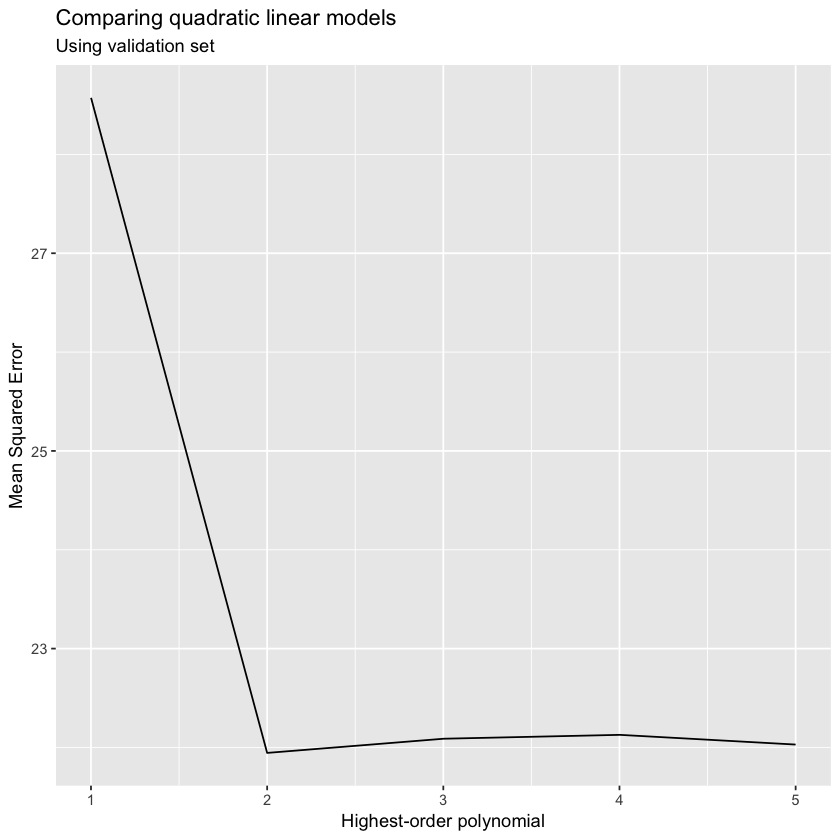

In [20]:
ggplot(auto_poly_results, aes(terms, MSE)) +
  geom_line() +
  labs(title = "Comparing quadratic linear models",
       subtitle = "Using validation set",
       x = "Highest-order polynomial",
       y = "Mean Squared Error")

### Drawbacks of the validation set approach

* High variability in estimating the test MSE
* Insufficient data for training. Most statistical learning methods perform better with more observations 

In [21]:
mse_variable <- function(Auto){
  auto_split <- resample_partition(Auto, c(test = 0.5, train = 0.5))
  auto_train <- auto_split$train %>%
    tbl_df()
  auto_test <- auto_split$test %>%
    tbl_df()

  results <- data_frame(terms = 1:5,
                        model = map(terms, ~glm(mpg ~ poly(horsepower, .), data = auto_train)),
                        MSE = map_dbl(model, mse, data = auto_test))

  return(results)
}

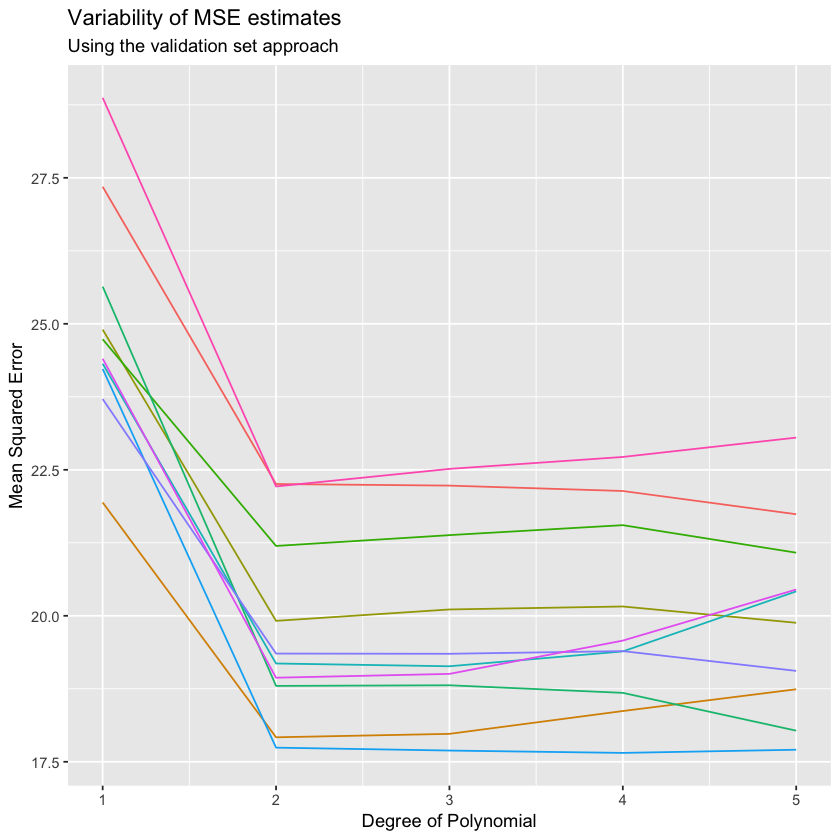

In [22]:
rerun(10, mse_variable(Auto)) %>%
  bind_rows(.id = "id") %>%
  ggplot(aes(terms, MSE, color = id)) +
  geom_line() +
  labs(title = "Variability of MSE estimates",
       subtitle = "Using the validation set approach",
       x = "Degree of Polynomial",
       y = "Mean Squared Error") +
  theme(legend.position = "none")

## Leave-one-out cross-validation

### For classification

In [23]:
mse.glm <- function (model, data){
  residuals.glm <- function(model, data) {
    modelr:::response(model, data) - stats::predict(model, data, type = "response")
  }
  
  x <- residuals(model, data)
  mean(x^2, na.rm = TRUE)
}

In [24]:
titanic_loocv <- crossv_kfold(titanic, k = nrow(titanic))

In [25]:
titanic_models <- map(titanic_loocv$train, ~ glm(Survived ~ Age * Sex, data = ., family = binomial))

In [26]:
titanic_mse <- map2_dbl(titanic_models, titanic_loocv$test, mse.glm)

In [27]:
mean(titanic_mse, na.rm = TRUE)

[1] 0.1703518

### For regression 

In [28]:
loocv_data <- crossv_kfold(Auto, k = nrow(Auto))
loocv_models <- map(loocv_data$train, ~ lm(mpg ~ horsepower, data = .))
loocv_mse <- map2_dbl(loocv_models, loocv_data$test, mse)
mean(loocv_mse)

[1] 24.23151

Compare the optimal number of polynomial terms

In [29]:
cv_error <- vector("numeric", 5)
terms <- 1:5

for(i in terms){
  loocv_models <- map(loocv_data$train, ~ lm(mpg ~ poly(horsepower, i), data = .))
  loocv_mse <- map2_dbl(loocv_models, loocv_data$test, mse)
  cv_error[[i]] <- mean(loocv_mse)
}

cv_mse <- data_frame(terms = terms, cv_MSE = cv_error)
cv_mse

terms,cv_MSE
1,24.23151
2,19.24821
3,19.33498
4,19.42443
5,19.03321


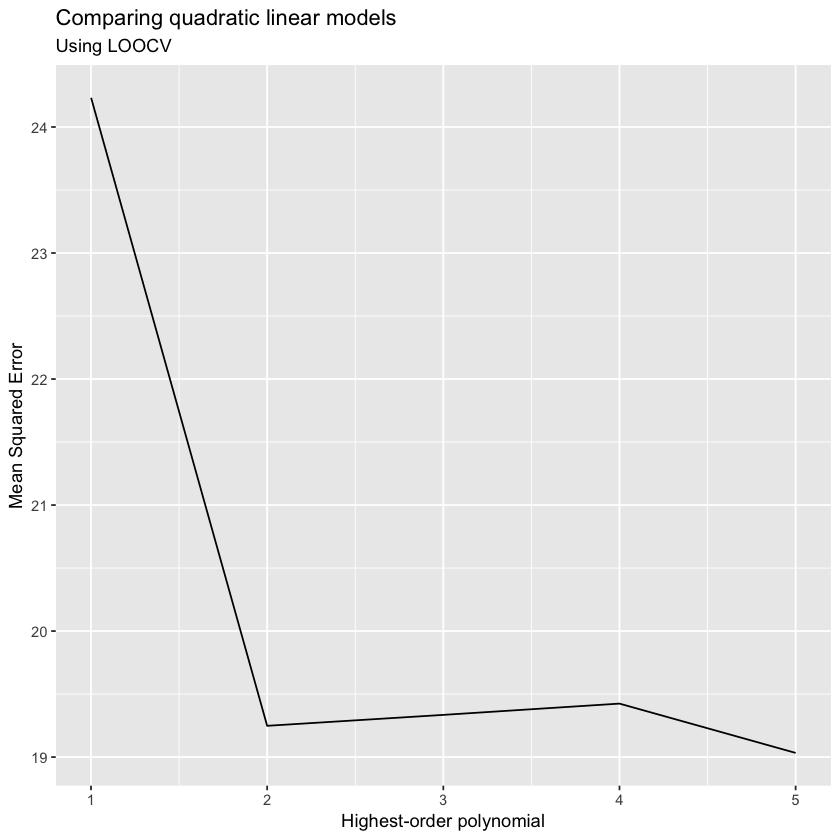

In [30]:
ggplot(cv_mse, aes(terms, cv_MSE)) +
  geom_line() +
  labs(title = "Comparing quadratic linear models",
       subtitle = "Using LOOCV",
       x = "Highest-order polynomial",
       y = "Mean Squared Error")

## k-fold cross-validation

In [31]:
cv10_data <- crossv_kfold(Auto, k = 10)

cv_error_fold10 <- vector("numeric", 5)
terms <- 1:5

for(i in terms){
  cv10_models <- map(cv10_data$train, ~ lm(mpg ~ poly(horsepower, i), data = .))
  cv10_mse <- map2_dbl(cv10_models, cv10_data$test, mse)
  cv_error_fold10[[i]] <- mean(cv10_mse)
}

cv_error_fold10

[1] 24.21061 19.24482 19.34964 19.38367 18.94861

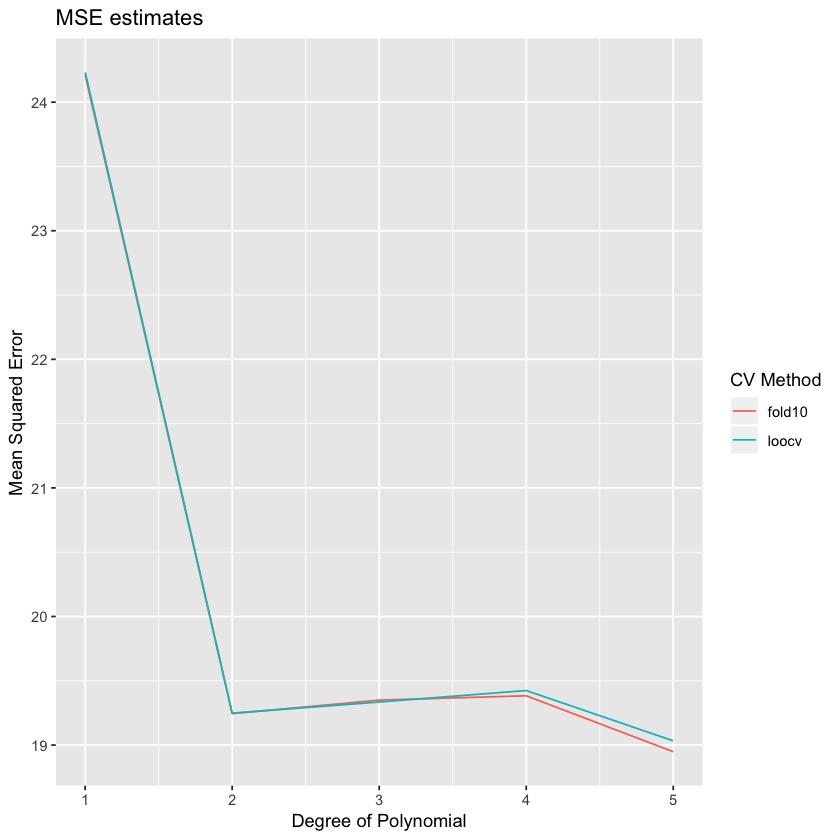

In [32]:
data_frame(terms = terms, loocv = cv_error, fold10 = cv_error_fold10) %>%
  gather(method, MSE, loocv:fold10) %>%
  ggplot(aes(terms, MSE, color = method)) +
  geom_line() +
  labs(title = "MSE estimates",
       x = "Degree of Polynomial",
       y = "Mean Squared Error",
       color = "CV Method")

## Computational speed of LOOCV vs. k-fold CV

In [33]:
library(profvis)

profvis({
  cv_error <- vector("numeric", 5)
  terms <- 1:5
  
  for(i in terms){
    loocv_models <- map(loocv_data$train, ~ lm(mpg ~ poly(horsepower, i), data = .))
    loocv_mse <- map2_dbl(loocv_models, loocv_data$test, mse)
    cv_error[[i]] <- mean(loocv_mse)
  }
})

HTML widgets cannot be represented in plain text (need html)

In [34]:
profvis({
  cv_error_fold10 <- vector("numeric", 5)
  terms <- 1:5
  
  for(i in terms){
    cv10_models <- map(cv10_data$train, ~ lm(mpg ~ poly(horsepower, i), data = .))
    cv10_mse <- map2_dbl(cv10_models, cv10_data$test, mse)
    cv_error_fold10[[i]] <- mean(cv10_mse)
  }
})

HTML widgets cannot be represented in plain text (need html)

# References

The demo materials are based on 
* https://cfss.uchicago.edu/stat005_resampling.html
* https://cfss.uchicago.edu/persp006_resampling.html#resampling_methods
* https://rstudio-pubs-static.s3.amazonaws.com/21668_28239bbc1ff34bc99f062f3241ca3a97.html#cross-validation